In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
df1 = pd.read_csv('../Datasets/SBIN-EQ_1m_6months.csv')
df = df1
df.head(3)

,Date,SBIN-EQ O,SBIN-EQ H,SBIN-EQ L,SBIN-EQ C,SBIN-EQ V
0,1/7/2021 18:00,287.7,287.7,287.7,287.7,0
1,1/7/2021 17:01,287.7,287.7,287.7,287.7,0
2,1/7/2021 16:58,287.7,287.7,287.7,287.7,0


In [3]:
df.shape

(15486, 6)

In [4]:
Close = []
for i in df['SBIN-EQ C'][::-1]:
    Close.append(i)

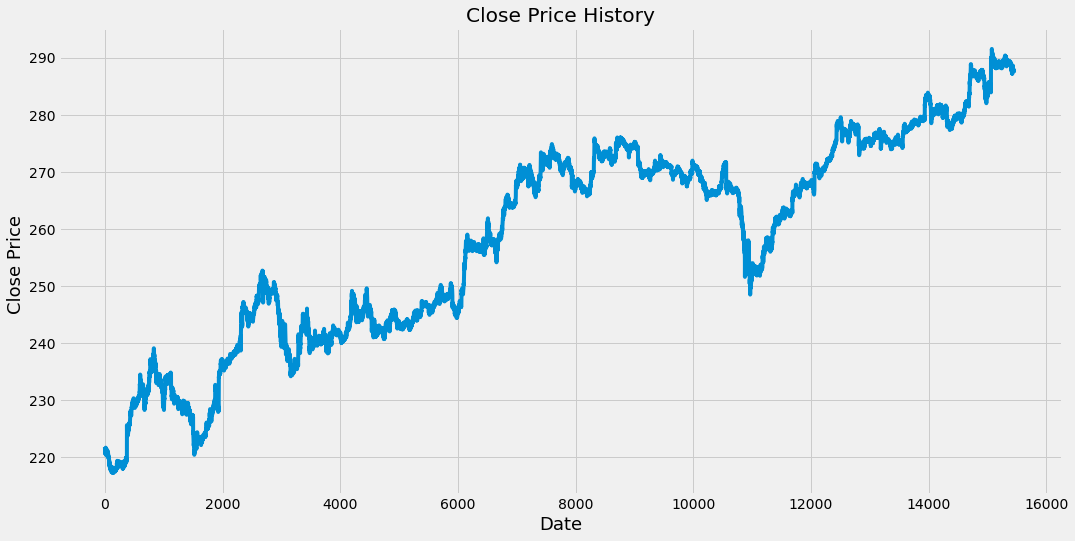

In [5]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(Close)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price ',fontsize=18)
plt.show()

In [6]:
df = pd.DataFrame({'Close':Close})

In [7]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])


#Converting the dataframe to a numpy array
dataset = data.values

#number of rows to train the data
training_data_len = math.ceil( len(dataset) *1)
training_data_len


15486

In [8]:
#Scale the all of the data to be values between 0 and 1 
#minmax scaling brings the value to the specufied range
scaler = MinMaxScaler(feature_range=(0, 1)) 

#fit and transform the data
scaled_data = scaler.fit_transform(dataset)


In [9]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
train_data

array([[0.06127946],
       [0.05993266],
       [0.04915825],
       ...,
       [0.94882155],
       [0.94882155],
       [0.94882155]])

In [10]:
for i in range(1,len(train_data)):
    x_train.append(train_data[i-1:i,0])
    y_train.append(train_data[i,0])
    if i<=1:
        print(x_train)
        print(y_train)
        print()

[array([0.06127946])]
[0.05993265993265995]



In [11]:
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(15485, 1)

In [28]:
y_train.shape

(15485,)

In [12]:
#Reshape the data
#2d into 3d
#Samples,Timesteps, Features
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(15485, 1, 1)

In [13]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [14]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')#loss = 'root_mean_squared_error'

In [15]:
model.fit(x_train, y_train, batch_size=4, epochs=100)

Epoch 1/100
3872/3872 [==============================] - 16s 4ms/step - loss: 0.0021
Epoch 2/100
3872/3872 [==============================] - 17s 4ms/step - loss: 3.6476e-05
Epoch 3/100
3872/3872 [==============================] - 16s 4ms/step - loss: 3.8744e-05
Epoch 4/100
3872/3872 [==============================] - 18s 5ms/step - loss: 4.0354e-05
Epoch 5/100
3872/3872 [==============================] - 16s 4ms/step - loss: 3.5358e-05
Epoch 6/100
3872/3872 [==============================] - 15s 4ms/step - loss: 3.5082e-05
Epoch 7/100
3872/3872 [==============================] - 17s 4ms/step - loss: 3.6787e-05
Epoch 8/100
3872/3872 [==============================] - 17s 4ms/step - loss: 3.2335e-05
Epoch 9/100
3872/3872 [==============================] - 17s 4ms/step - loss: 3.2536e-05
Epoch 10/100
3872/3872 [==============================] - 15s 4ms/step - loss: 3.3919e-05
Epoch 11/100
3872/3872 [==============================] - 16s 4ms/step - loss: 3.1369e-05
Epoch 12/100
3872/3872 

In [16]:
#serilizin the model to json
model_json = model.to_json()
with open("model_lstm.json","w") as json_file:
    json_file.write(model_json)
#serilizeing the model to HDF5    
model.save_weights("model_lstm.h5")
json_file = open('model_lstm.json','r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_lstm.h5")

#the above code helps to save time it loads the model into json file so we don't want to wait till the 40 epochs

    

In [17]:
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]  
for i in range(1,len(scaled_data)):
    x_test.append(scaled_data[i-1:i,0])


In [18]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [19]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [20]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)


<ipython-input-25-5e44ca7fdf37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


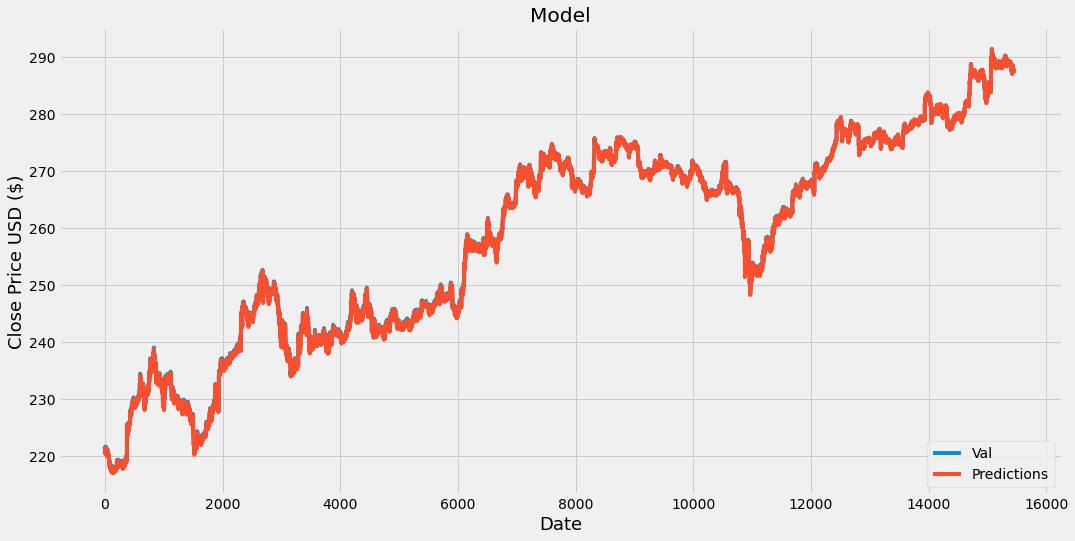

In [25]:
#Plot the data for the graph
data = df.filter(['Close'])
Dates = df.filter(['Date'])
valid = data[1:]
valid['Predictions'] = predictions
#valid['Date'] = Dates


#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(data)
#plt.plot(valid[['Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [45]:
input_x = np.array(Close[::-len(Close)]).reshape(1,-1)

In [48]:
input_x.shape  #(value,timeSteps)

(1, 1)

In [50]:
temp_input=list(input_x)
temp_input=temp_input[0].tolist()

In [51]:
temp_input

[287.7]